In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoTokenizer, T5ForConditionalGeneration
from sklearn.model_selection import train_test_split
import open_clip


2025-05-13 19:10:16.594042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 19:10:16.658643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 19:10:18.489271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_DIR = "mini_dataset_100/images"
REPORT_DIR = "mini_dataset_100/reports"
SPLITS_FILE = "mini_dataset_100/splits.csv"
HUGGINGFACE_TOKEN = "hf_your_token_here"  # Replace with HF token

label_cols = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]
NUM_LABELS = len(label_cols)
MAX_TEXT_LEN = 256
BATCH_SIZE = 4
EPOCHS = 5


In [3]:
split_df = pd.read_csv(SPLITS_FILE)


# === Build dataset ===
data = []
missing_reports = 0

for idx, row in split_df.iterrows():
    dicom_id = row['dicom_id']
    study_id = row['study_id']
    
    image_path = os.path.join(IMAGE_DIR, f"{dicom_id}.jpg")
    report_path = os.path.join(REPORT_DIR, f"s{study_id}.txt")
    
    # Check both image and report exist
    if os.path.exists(image_path) and os.path.exists(report_path):
        with open(report_path, "r", encoding="utf-8") as f:
            report = f.read().strip()
        data.append({
            "image_path": image_path,
            "report": report,
            "study_id": study_id,
            "dicom_id": dicom_id,
            "subject_id": row['subject_id'],
            "split": row['split']
        })
    else:
        missing_reports += 1

df = pd.DataFrame(data)
print(f"✅ Loaded {len(df)} valid image-report pairs.")
print(f"❌ Skipped {missing_reports} due to missing image or report.")

# Preview a few rows
df.head()

✅ Loaded 4000 valid image-report pairs.
❌ Skipped 0 due to missing image or report.


,image_path,report,study_id,dicom_id,subject_id,split
0,mini_dataset_100/images/02aa804e-bde0afdd-112c...,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,train
1,mini_dataset_100/images/174413ec-4ec4c1f7-34ea...,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,train
2,mini_dataset_100/images/2a2277a9-b0ded155-c0de...,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,train
3,mini_dataset_100/images/e084de3b-be89b11e-20fe...,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,train
4,mini_dataset_100/images/68b5c4b1-227d0485-9cc3...,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,train


In [4]:
df.to_csv("mini_dataset_100/image_report_dataset.csv", index=False)

In [5]:
# === Load splits ===
split_df = pd.read_csv(SPLITS_FILE)

# === Build dataset ===
records = []
for _, row in split_df.iterrows():
    dicom_id = row['dicom_id']
    study_id = row['study_id']
    image_path = os.path.join(IMAGE_DIR, f"{dicom_id}.jpg")
    report_path = os.path.join(REPORT_DIR, f"s{study_id}.txt")
    
    if os.path.exists(image_path) and os.path.exists(report_path):
        records.append({
            "image_path": image_path,
            "report_path": report_path,
            "study_id": study_id,
            "dicom_id": dicom_id,
            "subject_id": row['subject_id'],
            "split": row['split']
        })

df = pd.DataFrame(records)
print(f"✅ Valid image-report pairs found: {len(df)}")

# === Split into Train/Val/Test ===
train_val_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1111, random_state=42)  # ~10% of full set

# === Output stats ===
print(f"✅ Final Split Sizes:\nTrain: {len(train_df)}\nVal: {len(val_df)}\nTest: {len(test_df)}")

# === Optional Save ===
train_df.to_csv("mini_dataset_100/new_train.csv", index=False)
val_df.to_csv("mini_dataset_100/new_val.csv", index=False)
test_df.to_csv("mini_dataset_100/new_test.csv", index=False)

✅ Valid image-report pairs found: 4000
✅ Final Split Sizes:
Train: 3200
Val: 400
Test: 400


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

# === Load Clean Dataset ===
df = pd.read_csv("mini_dataset_100/new_train.csv")

In [7]:
labels_df = pd.read_csv("mini_dataset_100/chexpert_labels.csv")
print("Labels DF Columns:\n", labels_df.columns.tolist())

df = pd.read_csv("mini_dataset_100/new_train.csv")
print("\nTrain DF Columns:\n", df.columns.tolist())


Labels DF Columns:
 ['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

Train DF Columns:
 ['image_path', 'report_path', 'study_id', 'dicom_id', 'subject_id', 'split']


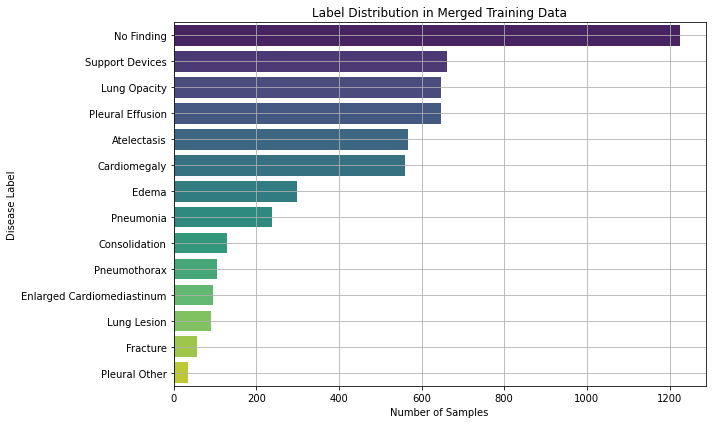

📊 Report Length Stats (in words):
count    3200.000000
mean       86.238750
std        34.826402
min        16.000000
25%        62.000000
50%        78.000000
75%       102.000000
max       291.000000
Name: report_len, dtype: float64


/tmp/ipykernel_30845/823420670.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


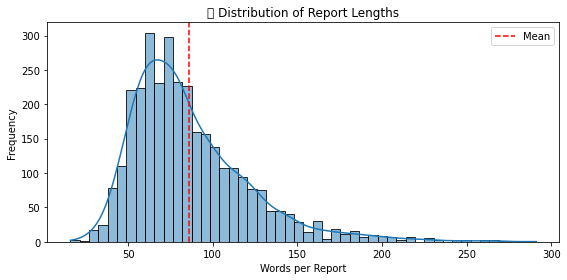

/tmp/ipykernel_30845/823420670.py:64: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  plt.tight_layout()
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


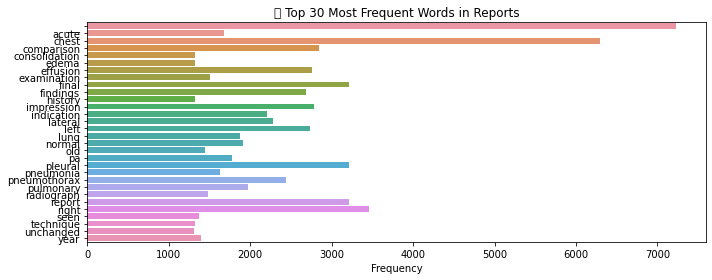

In [8]:
import numpy as np
# Load files
df = pd.read_csv("mini_dataset_100/new_train.csv")
labels_df = pd.read_csv("mini_dataset_100/chexpert_labels.csv")

# Merge on subject_id and study_id
merged_df = pd.merge(df, labels_df, on=["subject_id", "study_id"], how="inner")

# Replace uncertain labels (-1) with 1 or 0 as needed
# Option 1: Treat -1 as positive (aggressive)
# merged_df[label_cols] = merged_df[label_cols].replace(-1, 1)

# Option 2: Treat -1 as negative (conservative)

merged_df[label_cols] = merged_df[label_cols].replace(-1, 0)

# Compute label distribution
label_counts = merged_df[label_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title("Label Distribution in Merged Training Data")
plt.xlabel("Number of Samples")
plt.ylabel("Disease Label")
plt.tight_layout()
plt.grid(True)
plt.show()

# === 2. Report Text Analysis ===
def load_report(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

df["report_text"] = df["report_path"].apply(load_report)
df["report_len"] = df["report_text"].apply(lambda x: len(x.split()))

print("📊 Report Length Stats (in words):")
print(df["report_len"].describe())

# Plot report lengths
plt.figure(figsize=(8, 4))
sns.histplot(df["report_len"], bins=50, kde=True)
plt.axvline(df["report_len"].mean(), color='red', linestyle='--', label="Mean")
plt.title("📈 Distribution of Report Lengths")
plt.xlabel("Words per Report")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# === 3. Most Common Words (Optional Preprocessing Insight) ===
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df["report_text"])
word_freq = np.array(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 4))
sns.barplot(x=word_freq, y=words)
plt.title("📝 Top 30 Most Frequent Words in Reports")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# === 1. Load datasets ===
train_df = pd.read_csv("/home/u2/avikalsingh/mini_dataset_100/new_train.csv")
label_df = pd.read_csv("/home/u2/avikalsingh/mini_dataset_100/chexpert_labels.csv")

# === 2. Merge on study_id and subject_id ===
merged_df = pd.merge(train_df, label_df, on=['study_id', 'subject_id'], how='inner')

merged_df[label_cols] = merged_df[label_cols].replace(-1.0, 1.0).fillna(0.0)

# === 4. Explode multi-labels into single-label entries ===
exploded_rows = []
for _, row in merged_df.iterrows():
    for label in label_cols:
        if row[label] == 1.0:
            new_row = row.copy()
            new_row['disease_label'] = label
            exploded_rows.append(new_row)

exploded_df = pd.DataFrame(exploded_rows)

# === 5. Oversample minority classes ===
target_per_class = 400
balanced_dfs = []

for label in label_cols:
    label_df = exploded_df[exploded_df['disease_label'] == label]
    if len(label_df) < target_per_class:
        resampled = resample(label_df, replace=True, n_samples=target_per_class, random_state=42)
    else:
        resampled = label_df.sample(n=target_per_class, random_state=42)
    balanced_dfs.append(resampled)

balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

# === 6. Export to new file ===
balanced_df.to_csv("/home/u2/avikalsingh/mini_dataset_100/new_train_balanced.csv", index=False)
print("✅ Oversampled training data saved as 'new_train_balanced.csv'")


✅ Oversampled training data saved as 'new_train_balanced.csv'


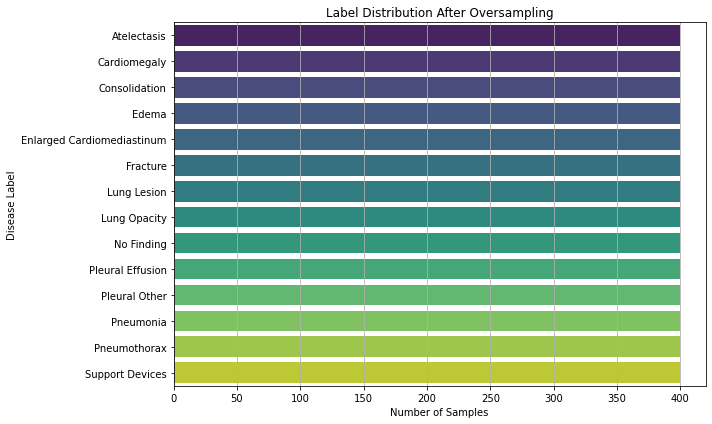

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the balanced dataset ===
balanced_df = pd.read_csv("/home/u2/avikalsingh/mini_dataset_100/new_train_balanced.csv")

# === Plot the distribution ===
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, y="disease_label", order=balanced_df["disease_label"].value_counts().index, palette="viridis")
plt.title("Label Distribution After Oversampling")
plt.xlabel("Number of Samples")
plt.ylabel("Disease Label")
plt.tight_layout()
plt.grid(axis='x')
plt.show()
